# Setup

In [26]:
import sqlite3
import mlflow
import mlflow.sklearn

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from feature_engine import imputation
from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from skopt import BayesSearchCV
from sklearn import metrics

In [27]:
# Importando os dados

path = r'C:\Users\franc\Data Science\Notebooks\o-list\data\olist.db'
with sqlite3.connect(path) as conn:
    query = 'SELECT * FROM abt_olist_churn'
    df = pd.read_sql_query(query, conn)

In [28]:
df.head()

,dtReference,idVendedor,qtdPedidos,qtdDiasComPedidos,qtItens,ticketMedio,avgValorProduto,maxValorProduto,minValorProduto,avgProdutoPorPedido,lifeTimeValue,qtdDiasPrimeiraVenda,qtdRecenciaVenda,avgIntervaloVendas,avgNota,minNota,maxNota,pctAvaliacao,qtdUFsDistintos,pctPedidoAC,pctPedidoAL,pctPedidoAM,pctPedidoAP,pctPedidoBA,pctPedidoCE,pctPedidoDF,pctPedidoES,pctPedidoGO,pctPedidoMA,pctPedidoMG,pctPedidoMS,pctPedidoMT,pctPedidoPA,pctPedidoPB,pctPedidoPE,pctPedidoPI,pctPedidoPR,pctPedidoRJ,pctPedidoRN,pctPedidoRO,pctPedidoRR,pctPedidoRS,pctPedidoSC,pctPedidoSE,pctPedidoSP,pctPedidoTO,pctPedidoCancelado,pctPedidosAtrasados,avgFrete,maxFrete,minFrete,avgDifDiasEntregaAprovado,avgDifDiasEntregaEstimativa,qtde_credit_card_pedido,qtde_boleto_pedido,qtde_debit_card_pedido,qtde_voucher_pedido,valor_credit_card_pedido,valor_boleto_pedido,valor_debit_card_pedido,valor_voucher_pedido,pct_qtd_credit_card_pedido,pct_qtd_boleto_pedido,pct_qtd_debit_card_pedido,pct_qtd_voucher_pedido,pct_valor_credit_card_pedido,pct_valor_boleto_pedido,pct_valor_debit_card_pedido,pct_valor_voucher_pedido,avgQtdParcelas,maxQtdParcelas,minQtdParcelas,qtdCategoriasVendedor,avgFotosVendedor,avgPesoGramas,avgVolProduto,minVolProduto,maxVolProduto,pctCategoria_cama_mesa_banho,pctCategoria_beleza_saude,pctCategoria_esporte_lazer,pctCategoria_informatica_acessorios,pctCategoria_moveis_decoracao,pctCategoria_utilidades_domesticas,pctCategoria_relogios_presentes,pctCategoria_telefonia,pctCategoria_automotivo,pctCategoria_brinquedos,pctCategoria_cool_stuff,pctCategoria_ferramentas_jardim,pctCategoria_perfumaria,pctCategoria_bebes,pctCategoria_eletronico,pctSalesOnTop15Category,flChurn
0,2017-10-01,0015a82c2db000af6aaaf3ae2ecb0532,1,1,1,895.000000,895.000000,895.000000,895.000000,1,895.000000,5.0,5.0,NaN,5.000000,5.0,5.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,1.000000,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.0000,21.020000,21.020000,21.02,9.066481,-23.000000,1,0,0,0,916.020020,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0000,10.000000,10.0,10.0,1,2.0,11800.000000,61920.000000,61920.0,61920.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2017-11-01,0015a82c2db000af6aaaf3ae2ecb0532,3,3,1,895.000000,895.000000,895.000000,895.000000,1,2685.000000,36.0,14.0,11.000000,3.666667,1.0,5.0,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.333333,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.0000,21.020000,21.020000,21.02,9.497693,-16.333333,3,0,0,0,2748.060059,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0000,7.333333,10.0,4.0,1,2.0,11800.000000,61920.000000,61920.0,61920.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2017-12-01,0015a82c2db000af6aaaf3ae2ecb0532,3,3,1,895.000000,895.000000,895.000000,895.000000,1,2685.000000,66.0,44.0,11.000000,3.666667,1.0,5.0,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.000,0.0,0.0,0.0,0.0,0.333333,0.0000,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000,0.0000,0.0,0.0000,21.020000,21.020000,21.02,9.497693,-16.333333,3,0,0,0,2748.060059,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.0000,7.333333,10.0,4.0,1,2.0,11800.000000,61920.000000,61920.0,61920.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2017-03-01,001cca7ae9ae17fb1caed9dfb1094831,5,4,1,219.780003,99.900002,99.900002,99.900002,2,1098.900017,25.0,2.0,7.666667,4.200000,2.0,5.0,1.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.400,0.0,0.0,0.0,0.0,0.000000,0.2000,0.0,0.0,0.0,0.2000,0.0000,0.0,0.200,0.0000,0.0,0.0000,39.299999,74.349999,16.40,15.088567,-18.200000,4,1,0,0,1053.299988,242.100006,0.0,0.000000,0.800000,0.200000,0.0,0.000000,0.813108,0.186892,0.0,0.0000,7.000000,10.0,4.0,1,4.0,8875.000000,24080.000000,24080.0,24080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,2017-04-01,001cca7ae9ae17fb

# Exploratory Data Analysis

Primeiro, vamos olhar se temos algum missing no nosso dataset.

In [29]:
df.isnull().sum().sort_values(ascending=False).head(15)

avgIntervaloVendas             1408
avgQtdParcelas                  385
maxQtdParcelas                  385
minQtdParcelas                  385
pctPedidosAtrasados             176
maxNota                           9
minNota                           9
avgNota                           9
minVolProduto                     1
maxVolProduto                     1
avgVolProduto                     1
avgDifDiasEntregaAprovado         1
valor_voucher_pedido              0
pct_valor_debit_card_pedido       0
pct_valor_boleto_pedido           0
dtype: int64

Temos alguns valores missing! Vamos lidar com eles após realizar a separação dos dados em treino e teste, para evitar vazamento de dados.

Vamos olhar os tipos de dados que temos!

In [30]:
df.dtypes.value_counts()

float64    82
int64      11
object      2
dtype: int64

In [31]:
df.dtypes[df.dtypes == 'object']

dtReference    object
idVendedor     object
dtype: object

Apenas temos duas variáveis categóricas, que são 'dtReference' e 'idVendedor'. Porém não precisamos nos preocupar com essas variáveis, visto que serão removidas do nosso vetor X.

Vamos olhar a distribuição da nossa variável target.

Churn proportion: 0.3237493417588204


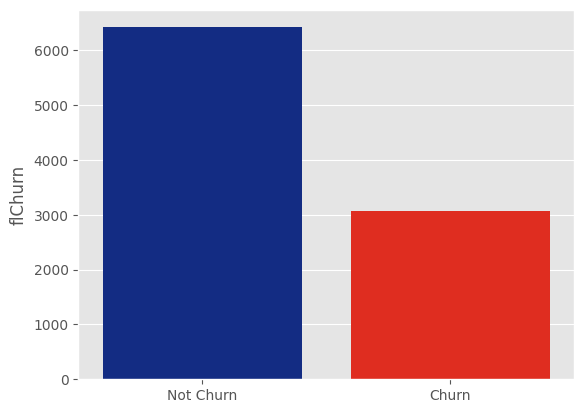

In [32]:
palette = ["#002296", "#ff1100"]
sns.set_palette(palette)
sns.barplot(x=['Not Churn', 'Churn'], y=df['flChurn'].value_counts());
churn_proportion = df['flChurn'].mean()

print('Churn proportion:', churn_proportion);

Note que nossa target é levemente desbalanceada. Por conta disso, não precisamos usar nenhuma tecnica de balanceamento.

Vamos olhar as estatísticas dos nossos dados.

In [33]:
df.describe()

,qtdPedidos,qtdDiasComPedidos,qtItens,ticketMedio,avgValorProduto,maxValorProduto,minValorProduto,avgProdutoPorPedido,lifeTimeValue,qtdDiasPrimeiraVenda,qtdRecenciaVenda,avgIntervaloVendas,avgNota,minNota,maxNota,pctAvaliacao,qtdUFsDistintos,pctPedidoAC,pctPedidoAL,pctPedidoAM,pctPedidoAP,pctPedidoBA,pctPedidoCE,pctPedidoDF,pctPedidoES,pctPedidoGO,pctPedidoMA,pctPedidoMG,pctPedidoMS,pctPedidoMT,pctPedidoPA,pctPedidoPB,pctPedidoPE,pctPedidoPI,pctPedidoPR,pctPedidoRJ,pctPedidoRN,pctPedidoRO,pctPedidoRR,pctPedidoRS,pctPedidoSC,pctPedidoSE,pctPedidoSP,pctPedidoTO,pctPedidoCancelado,pctPedidosAtrasados,avgFrete,maxFrete,minFrete,avgDifDiasEntregaAprovado,avgDifDiasEntregaEstimativa,qtde_credit_card_pedido,qtde_boleto_pedido,qtde_debit_card_pedido,qtde_voucher_pedido,valor_credit_card_pedido,valor_boleto_pedido,valor_debit_card_pedido,valor_voucher_pedido,pct_qtd_credit_card_pedido,pct_qtd_boleto_pedido,pct_qtd_debit_card_pedido,pct_qtd_voucher_pedido,pct_valor_credit_card_pedido,pct_valor_boleto_pedido,pct_valor_debit_card_pedido,pct_valor_voucher_pedido,avgQtdParcelas,maxQtdParcelas,minQtdParcelas,qtdCategoriasVendedor,avgFotosVendedor,avgPesoGramas,avgVolProduto,minVolProduto,maxVolProduto,pctCategoria_cama_mesa_banho,pctCategoria_beleza_saude,pctCategoria_esporte_lazer,pctCategoria_informatica_acessorios,pctCategoria_moveis_decoracao,pctCategoria_utilidades_domesticas,pctCategoria_relogios_presentes,pctCategoria_telefonia,pctCategoria_automotivo,pctCategoria_brinquedos,pctCategoria_cool_stuff,pctCategoria_ferramentas_jardim,pctCategoria_perfumaria,pctCategoria_bebes,pctCategoria_eletronico,pctSalesOnTop15Category,flChurn
count,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,8087.000000,9486.000000,9486.000000,9486.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.00000,9495.000000,9495.000000,9495.000000,9319.000000,9495.000000,9495.000000,9495.000000,9494.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9110.000000,9110.000000,9110.000000,9495.000000,9495.000000,9495.000000,9494.000000,9494.000000,9494.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.000000,9495.0,9495.000000,9495.000000
mean,23.328067,16.358926,10.019063,179.825092,162.943121,300.694172,97.991213,1.060242,3591.085897,138.192101,13.014007,17.230155,4.088420,2.269977,4.787898,0.991341,5.817378,0.001409,0.005915,0.002297,0.000906,0.036716,0.014035,0.022534,0.020004,0.020743,0.007284,0.117093,0.006717,0.010984,0.012034,0.006563,0.017273,0.005596,0.051735,0.138700,0.005579,0.003405,0.000558,0.060432,0.038265,0.00460,0.385330,0.003294,0.010243,0.053394,24.797665,50.872402,15.194819,13.598561,-12.309588,17.794839,4.913533,0.215377,1.022328,2851.163930,705.879941,22.065216,92.964231,0.746032,0.206562,0.008986,0.038419,0.755375,0.206557,0.007966,0.030102,3.918066,7.508562,1.899341,2.003160,2.244130,2721.699715,19158.995193,10724.936276,36214.814093,0.042031,0.083047,0.101644,0.059876,0.086395,0.066991,0.018171,0.025190,0.050423,0.039726,0.037412,0.040234,0.027741,0.027373,0.0,0.706255,0.323749
std,56.083538,25.066385,17.591865,288.672054,263.446076,435.065568,224.888927,0.384219,9634.964512,112.819269,11.969570,21.874357,0.822115,1.578172,0.764476,0.048040,4.898177,0.021958,0.045799,0.027508,0.014214,0.101803,0.065176,0.089147,0.071170,0.079402,0.043321,0.173554,0.043648,0.058392,0.058704,0.043798,0.069213,0.044408,0.119319,0.189847,0.039817,

Podemos analisar a distribuição da quantidade de pedidos dos vendedores!

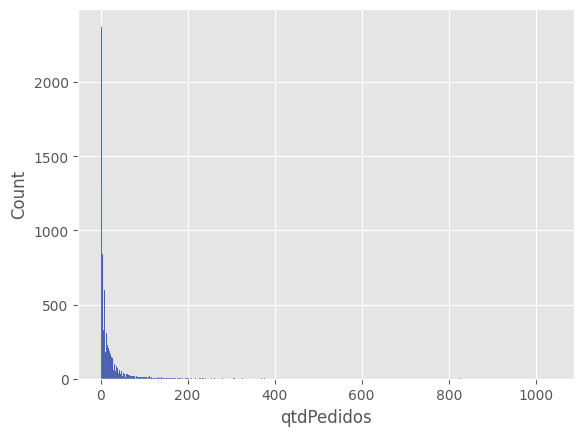

In [34]:
sns.histplot(df['qtdPedidos']);

Para obsevar melhor os dados, iremos realizar um corte no percentil 99 da quantidade de pedidos.

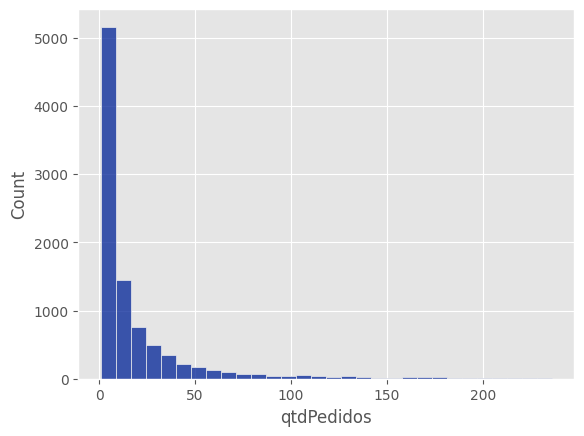

In [35]:
p99 = np.percentile(df['qtdPedidos'], 99)
sns.histplot(df['qtdPedidos'][df['qtdPedidos'] < p99], bins=30);

Podemos olhar mais a fundo ainda os vendedores que tiveram entre 1 a 50 pedidos:

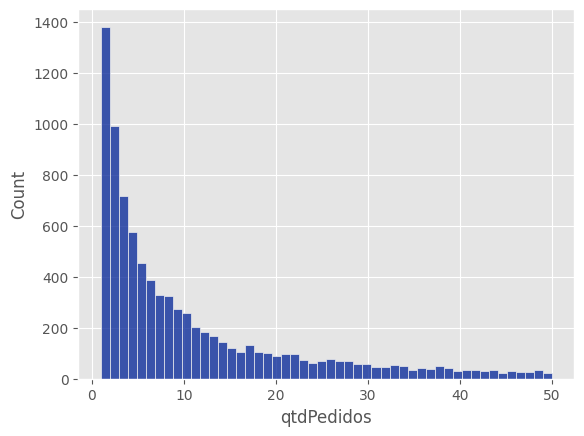

In [36]:
sns.histplot(df['qtdPedidos'][df['qtdPedidos'] <= 50], bins=50);

Pode-se observar que a proporção de vendedores que realizaram apenas de 1 a 5 pedidos é grande. Podemos observar se isso possui alguma relação com nossa target.

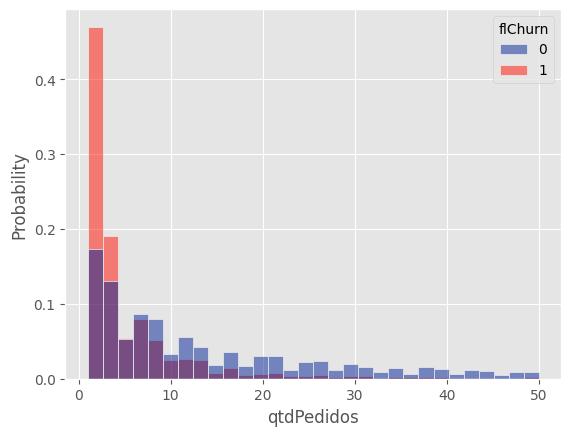

In [37]:
sns.histplot(x="qtdPedidos", hue="flChurn", bins=30,
             stat="probability", data=df[df["qtdPedidos"] <= 50],
             common_norm=False);

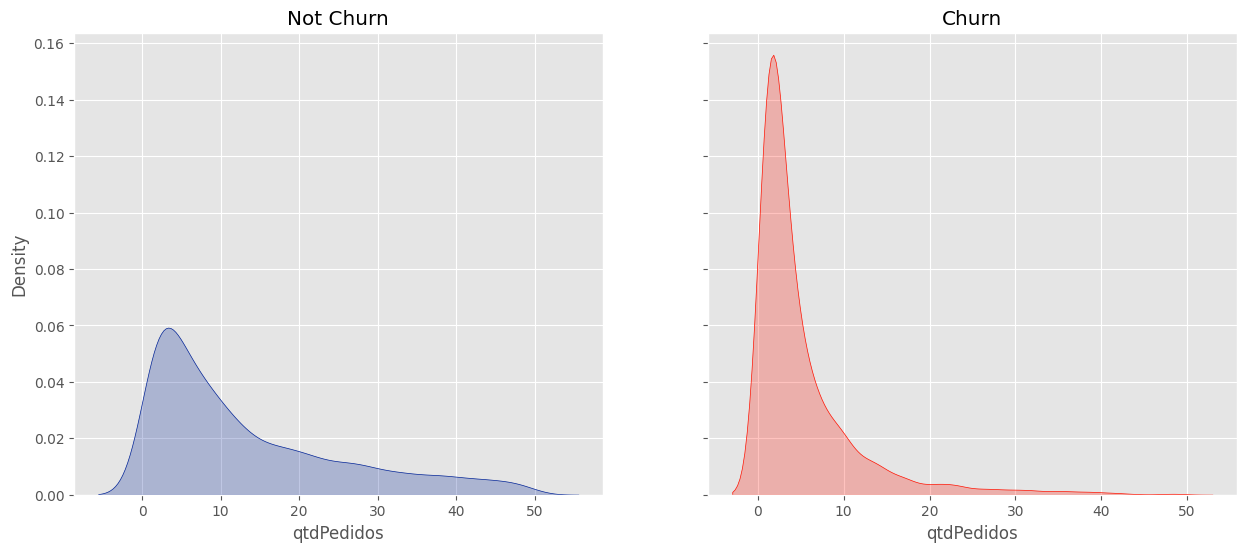

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.kdeplot(x='qtdPedidos', data=df[(df["flChurn"] == 0) & (
    df['qtdPedidos'] < 50)], color=palette[0], ax=ax1, fill=True)
sns.kdeplot(x='qtdPedidos', data=df[(df["flChurn"] == 1) & (
    df['qtdPedidos'] < 50)], color=palette[1], ax=ax2, fill=True)
ax1.set_title("Not Churn")
ax2.set_title("Churn");

Temos um padrão na quantidade de vendas com o churning. Podemos observar que a probabilidade de um vendedor Churn ter entre 0 a 5 vendas é de 0.7, enquanto para um vendedor não churn, a probabilidade dele ter de 0 a 5 vendas é em torno de 0.35.

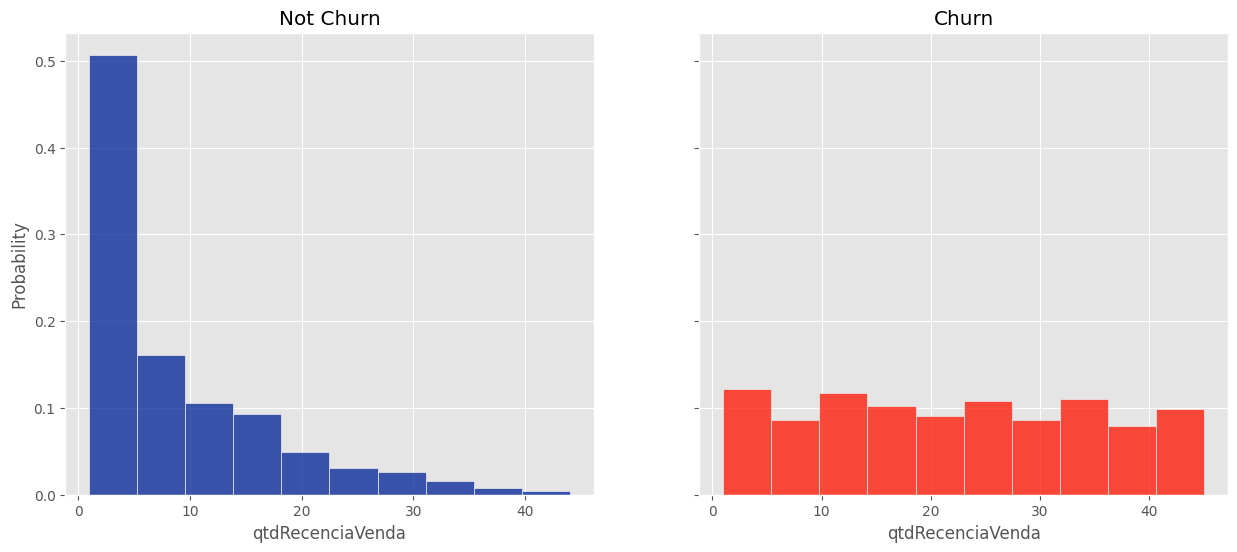

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
sns.histplot(x='qtdRecenciaVenda', data=df[(df["flChurn"] == 0)],
             stat="probability", bins= 10, color = palette[0],ax=ax1)
sns.histplot(x='qtdRecenciaVenda', data=df[(df["flChurn"] == 1)],
             stat="probability", bins=10, color= palette[1], ax=ax2)
ax1.set_title("Not Churn")
ax2.set_title("Churn");

Temos um padrão claro na Recência (quantidade de dias sem venda) em relação ao Churn. Pode-se observar que quanto mais próximo de 45, a quantidade de vendedores churn diminui. Isso se deve ao fato do churn ser definido diretamente pela variável recência. Com isso, iremos remover essa variável do modelo para evitar vazamento de dados.

# Data Splitting

Iremos dividir nosso dataset em 3 partes: Treino, teste e uma base out of time. Dessa forma, conseguimos não só validar nosso modelo em dados não treinados, mas também em dados em uma janela temporal distinta.

In [40]:
int_columns = df.select_dtypes(include=['int64']).columns
df[int_columns] = df[int_columns].astype(float)

In [41]:
df['dtReference'].value_counts()

2018-01-01    1068
2017-12-01    1051
2018-02-01    1047
2017-11-01     875
2017-10-01     844
2017-09-01     779
2017-08-01     680
2017-06-01     652
2017-07-01     642
2017-05-01     580
2017-04-01     568
2017-03-01     481
2017-02-01     227
2017-01-01       1
Name: dtReference, dtype: int64

In [42]:
# criando uma base out of time

df_oot = df[df['dtReference'] == '2018-02-01']

df_train = df[df['dtReference'] != '2018-02-01']

In [43]:
df_train.shape, df_oot.shape

((8448, 95), (1047, 95))

Agora iremos remover algumas features do nosso dataset. Como visto anteriormente, iremos remover também a feature qtdRecênciaVenda, para evitar vazamento de dados, visto que a target é definida a partir dessa variável.

In [44]:
var_identity = ['dtReference', 'idVendedor']
target = ['flChurn']
to_remove = ['qtdRecenciaVenda'] + target + var_identity

features = df.columns.tolist()
features = list(set(features) - set(to_remove))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train[features], df_train[target].values.ravel(), test_size=0.2, random_state=23)

In [46]:
X_oot = df_oot[features]
y_oot = df_oot['flChurn']

In [47]:
(X_train.shape[0] + X_test.shape[0] + df_oot.shape[0]), df.shape[0]

(9495, 9495)

# Pre Processing

Após realizarmos o split dos dados, devemos realizar o pré processamento. É importante seguir essa ordem para evitar vazamento de dados. Por exemplo, se imputarmos valores missing antes de realizar a divisão das bases, podemos enviesar o nosso modelo.

In [48]:
X_train.isnull().sum().sort_values(ascending=False)

avgIntervaloVendas              1087
maxQtdParcelas                   293
avgQtdParcelas                   293
minQtdParcelas                   293
pctPedidosAtrasados              139
                                ... 
pctSalesOnTop15Category            0
pct_qtd_voucher_pedido             0
pctPedidoTO                        0
pctCategoria_cama_mesa_banho       0
pctCategoria_telefonia             0
Length: 91, dtype: int64

Temos diversos valores missing no nosso dataset. Para realizar a imputação desses dados, devemos primeiro entender o motivo dos dados estarem faltantes, e então definir uma estratégia de imputação.

Nesse caso, existem vários motivos. Algumas features estão com missing pois não existem, como por exemplo maxNota, avgNota. Para esses casos, iremos imputar o valor -1. Não escolheremos imputar média/mediana/zero, pois estaríamos atribuindo um valor que não corresponde à realidade.

Já em outros casos, iremos imputar o número zero, como por exemplo nas features relacionadas à parcelas. O motivo de estarem missing é por conta dos vendedor não ter feito nenhuma venda parcelada. Logo, o número de parcelas será 0.

In [49]:
missing_minus_1 = ['avgIntervaloVendas', 'pctPedidosAtrasados', 'maxNota', 'avgNota',
                   'minNota', 'minVolProduto', 'maxVolProduto', 'avgDifDiasEntregaAprovado', 'avgVolProduto']

missing_zero = ['maxQtdParcelas', 'minQtdParcelas', 'avgQtdParcelas']

In [50]:
imputer_minus_1 = imputation.ArbitraryNumberImputer(arbitrary_number=-1,
                                                    variables=missing_minus_1)

imputer_zero = imputation.ArbitraryNumberImputer(arbitrary_number=0,
                                                 variables=missing_zero)

scaler = preprocessing.MinMaxScaler()

# Modeling

Iremos usar a plataforma MLflow para experimentar nossos modelos.

In [51]:
mlflow.set_experiment(experiment_name='olist_churn_prediction')
mlflow.sklearn.autolog()

In [104]:
%%capture
with mlflow.start_run(run_name='lgbm_tuned_pruned'):

    model = LGBMClassifier(random_state=23)

    space_lgbm = {'learning_rate': (1e-3, 0.5e-1),
                'num_leaves': (2,128),
                'min_child_samples': (50,100),
                'subsample': (0.05, 1),
                'colsample_bytree': (0.1, 1),
                'max_depth': (3,9)
                }

    space_rf = {'n_estimators': (100, 200),
                'max_features': (None, 'sqrt', 'log2'),
                'max_depth': (3, 20),
                'min_samples_leaf': (10, 100)
               }

    bayes_search = BayesSearchCV(model, space_lgbm, cv=5, scoring='roc_auc',
                                 n_iter= 20, verbose=1, random_state=23)

    pipeline = Pipeline([
                        ('imputation_minus_1', imputer_minus_1),
                        ('imputation_0', imputer_zero),
                        ('bayes_search', bayes_search)
                        ])
    
    pipeline.fit(X_train, y_train)
    
    #metricas de treino
    y_train_pred = pipeline.predict(X_train)
    y_train_score = pipeline.predict_proba(X_train)[:, 1]

    train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    train_precision = metrics.precision_score(y_train, y_train_pred)
    train_recall = metrics.recall_score(y_train, y_train_pred)
    train_f1_score = metrics.f1_score(y_train, y_train_pred)
    train_auc = metrics.roc_auc_score(y_train, y_train_score)
    
    #metricas de teste
    y_test_pred = pipeline.predict(X_test)
    y_test_score = pipeline.predict_proba(X_test)[:, 1]
    
    test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
    test_precision = metrics.precision_score(y_test, y_test_pred)
    test_recall = metrics.recall_score(y_test, y_test_pred)
    test_f1_score = metrics.f1_score(y_test, y_test_pred)
    test_auc = metrics.roc_auc_score(y_test, y_test_score)
    
    #metricas da base out of time
    y_oot_pred = pipeline.predict(X_oot)
    y_oot_score = pipeline.predict_proba(X_oot)[:, 1]
    
    oot_accuracy = metrics.accuracy_score(y_oot, y_oot_pred)
    oot_precision = metrics.precision_score(y_oot, y_oot_pred)
    oot_recall = metrics.recall_score(y_oot, y_oot_pred)
    oot_f1_score = metrics.f1_score(y_oot, y_oot_pred)
    oot_auc = metrics.roc_auc_score(y_oot, y_oot_score)

    model_metrics = {"accuracy_train": train_accuracy,
                    "accuracy_test": test_accuracy,
                    "precision_train": train_precision,
                    "precision_test": test_precision,
                    "recall_train": train_recall,
                    "recall_test": test_recall,
                    "f1_score_train": train_f1_score,
                    "f1_score_test": test_f1_score,
                    "auc_train": train_auc,
                    "auc_test": test_auc,
                    "accuracy_oot": oot_accuracy,
                    "precision_oot": oot_precision,
                    "recall_oot": oot_recall,
                    "f1_score_oot": oot_f1_score,
                    "auc_oot": oot_auc}
    
    mlflow.log_metrics(model_metrics)
    mlflow.sklearn.log_model(model, "rf")

Vamos calcular o melhor ponto de corte para o modelo. Para isso, o cenário ideal seria definir uma função de custo de acordo com o custo de cada erro (Tipo I e Tipo II).

> Por exemplo, imagine que pra cada vendedor churn que o modelo prevê como não churn (erro do tipo II), o custo de perda desse vendedor seja aproximado por 1.000 reais, e pra cada vendedor não churn que o modelo prevê churn (erro do tipo I), a empresa enviará um e-mail com redução nas taxas para estimular este vendedor, com o custo gerado médio de 200 reais.

> Logo podemos criar uma função da seguinte forma: C(x,y) = 1000x + 200y, onde x será o falso positivo (erro tipo I), e y o falso negativo (erro tipo II). Com isso, podemos usar essa função como indicador do modelo, e calcular o ponto de corte que minimize essa função!

> Como não temos essa função, iremos escolher o ponto de corte que maximize o índice de Youden, definido por J = Sensibilidade + Especificidade - 1)

In [103]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = metrics.roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])

threshold = Find_Optimal_Cutoff(y_train, y_train_score)[0]

print('Ponto de corte:', threshold)

Ponto de corte: 0.3886268897132171


# Model Evaluation

Primeiro, criaremos uma função para nos ajudar a avaliar nossos modelos.

In [83]:
def evaluate_model(target, predicted, y_score, normalize_matrix= None):
    accuracy = metrics.accuracy_score(target, predicted)
    precision = metrics.precision_score(target, predicted)
    recall = metrics.recall_score(target, predicted)
    f1 = metrics.f1_score(target, predicted)
    auc = metrics.roc_auc_score(target, y_score)

    confusion_matrix = metrics.confusion_matrix(
        target, predicted, normalize=normalize_matrix)
    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix, display_labels=[False, True])
    cm_display.plot()
    plt.grid(False)
    plt.show()

    fpr, tpr, threshold = metrics.roc_curve(target, y_score)
    plt.plot(fpr, tpr, label="Model", c="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", c="yellow")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    print("Accuracy", accuracy.round(2))
    print("Precision:", precision.round(2))
    print("Recall:", recall.round(2))
    print("F1 Score", f1.round(2))
    print("AUC:", auc)
    return None

Avaliando nosso modelo no ponto de corte padrão (0.5)

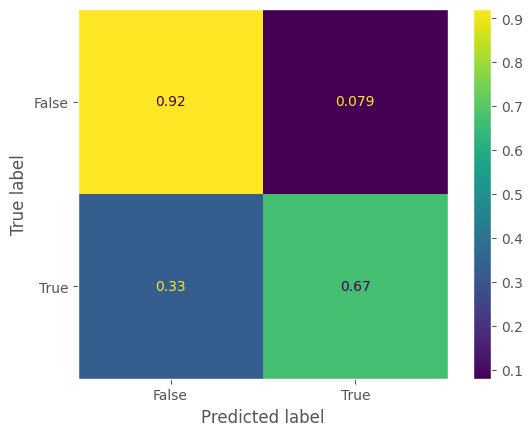

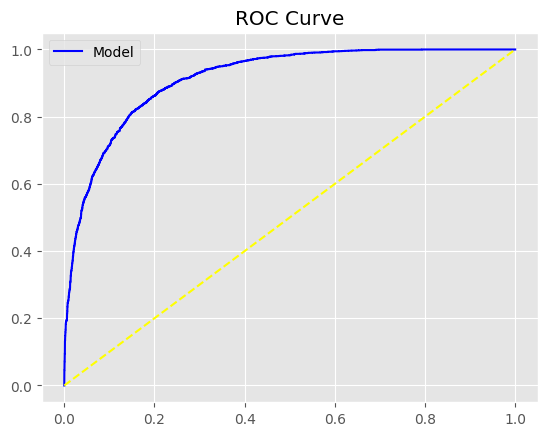

Accuracy 0.84
Precision: 0.8
Recall: 0.67
F1 Score 0.73
AUC: 0.9140296966204555


In [84]:
evaluate_model(y_train, y_train_pred, y_train_score, normalize_matrix='true')

Agora podemos avaliar no ponto de corte ótimo (~0.38)

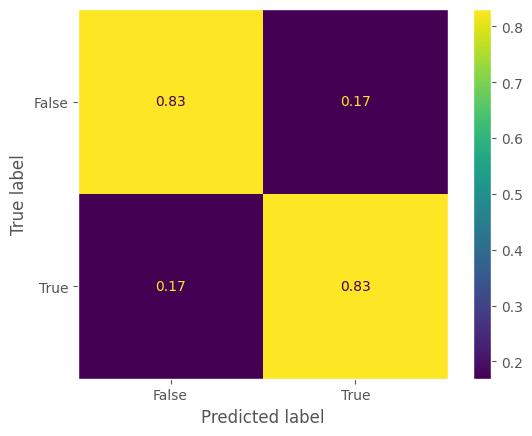

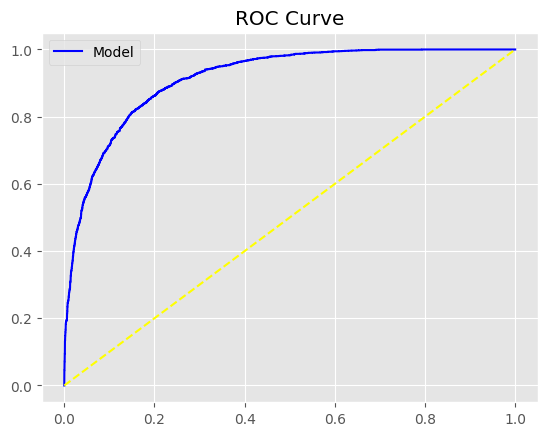

Accuracy 0.83
Precision: 0.71
Recall: 0.83
F1 Score 0.76
AUC: 0.9140296966204555


In [100]:
evaluate_model(y_train, (y_train_score > threshold), y_train_score, normalize_matrix='true')